![](img/330-banner.png)

# Lecture 15: DBSCAN and Recommender Systems

UBC 2022 Summer

Instructor: Mehrdad Oveisi

## Imports

In [1]:
import os
import random
import sys
import time

import numpy as np

sys.path.append("code/.")
import matplotlib.pyplot as plt
from plotting_functions import *
from plotting_functions_unsup import *
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 16
import matplotlib.cm as cm

# plt.style.use("seaborn")
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

## Learning outcomes <a name="lo"></a>

From this lecture, students are expected to be able to:
- Identify limitations of K-Means.
- Explain how DBSCAN works at a high level.
- Use `sklearn` to apply DBSCAN. 
- Explain the effect of epsilon and minimum samples hyperparameters in DBSCAN.  
- Identify DBSCAN limitations.
- State the problem of recommender systems. 
- Describe components of a utility matrix. 
- Create a utility matrix given ratings data. 
- Describe a common approach to evaluate recommender systems. 
- Implement some baseline approaches to complete the utility matrix. 
- Explain the idea of collaborative filtering. 
- Explain some serious consequences of recommendation systems. 

## Another useful clustering algorithm: DBSCAN

### K-Means recap 
- We discussed K-Means clustering in the previous lecture. 
- Each cluster is represented by a center. 
- Given a new point, you can assign it to a cluster by computing the distances to all cluster centers and picking the cluster with the smallest distance. 
- It's a popular algorithm because 
    - It's easy to understand and implement.
    - Runs relatively quickly and scales well to large datasets. 
    - `sklearn` has a more scalable variant called [`MiniBatchKMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) which can handle very large datasets. 

### K-Means limitations

- Relies on random initialization and so the outcome may change depending upon this initialization. 
- K-Means clustering requires to specify the number of clusters in advance.
- Very often you do not know the centers in advance. The elbow method or the silhouette method to find the optimal number of clusters are not always easy to interpret. 
- Each point has to have a cluster assignment. 

### K-Means limitations: Shape of K-Means clusters

- K-Means partitions the space based on the closest mean. 
- Each cluster is defined solely by its center and so it can only **capture relatively simple shapes**. 
- So the **boundaries** between clusters are **linear**; It fails to identify clusters with **complex shapes**. 

![](img/kmeans_boundaries.png)

<!-- <img src="img/kmeans_boundaries.png" alt="" height="500" width="500">  -->
    

[Source](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)

### K-Means: failure case 1

- K-Means performs poorly if the clusters have more complex shapes (e.g., two moons data below). 

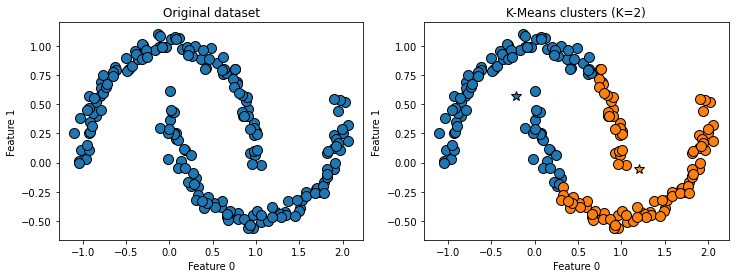

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=42)
plot_X_k_means(X, k=2)

### K-Means: failure case 2

- It assumes that **all directions are equally important** for each cluster and fails to identify non-spherical clusters. 

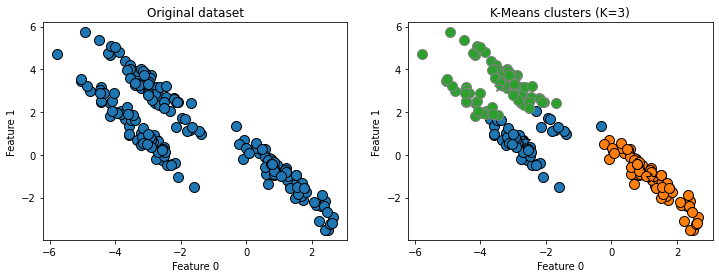

In [3]:
# generate some random cluster data
X, y = make_blobs(random_state=170, n_samples=200)
rng = np.random.RandomState(74)
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)
plot_X_k_means(X, 3)

### K-Means: failure case 3 

- Again, K-Means is unable to capture complex cluster shapes. 

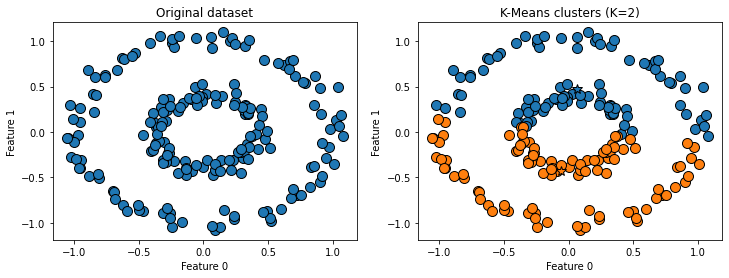

In [4]:
X = datasets.make_circles(n_samples=200, noise=0.06, factor=0.4)[0]
plot_X_k_means(X, 2)

- Can we do better than this? 
- Another clustering algorithm called DBSCAN is able to tackle some of these cases. 

### DBSCAN

- **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise
- Intuitively, it's based on the idea that **clusters form dense regions** in the data and so it works by **identifying "crowded" regions** in the feature space. 
- It can address some of the limitations of K-Means we saw above. 
    - It does not require the user to specify the number of clusters in advance. 
    - It can identify points that are not part of any clusters. 
    - It can capture clusters of complex shapes. 

Let's try `sklearn`'s DBSCAN.   

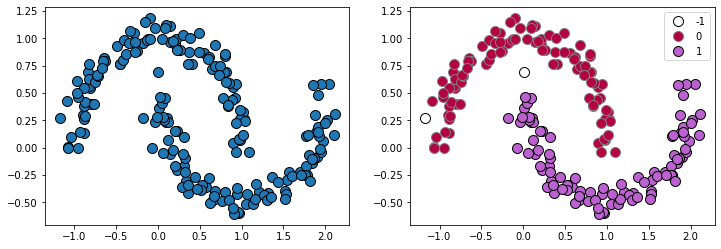

In [5]:
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=200, noise=0.08, random_state=42)
dbscan = DBSCAN(eps=0.2)
dbscan.fit(X)
plot_X_dbscan(X, dbscan)

In [6]:
dbscan.labels_

array([ 0,  0,  0,  1,  1,  1,  0,  1,  1,  0,  0,  1,  1,  0,  1,  1,  0,
        1,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  0,  0,  1,  0,  0,  1,  1,  0,  0,  1,  0,  1,
        1,  0,  1,  1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  1,  0,  1,
        0,  1,  0,  1,  1,  0,  1,  1,  0,  1, -1,  1,  0,  0,  0,  1,  1,
        0,  1,  0,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  1,  0,  0,
        1,  1,  1,  1,  0,  0,  1,  1,  1,  0,  1,  1,  0,  1,  0,  0,  1,
        0,  0,  1,  1,  1,  0,  0,  1,  1,  0,  0,  1,  0,  0,  1,  0,  1,
        0,  1,  0,  1,  1,  1,  1,  0,  0,  0,  0,  1,  0,  0,  1,  1,  0,
        0,  0,  0,  1,  1,  0,  0,  1,  1,  1,  1,  0,  0,  1,  0,  1,  0,
        0,  0,  0,  0,  1,  1,  1,  0,  1,  1,  0,  0,  1,  1,  1,  1,  0,
        1,  0,  0,  1,  1,  0,  1,  0,  1,  0, -1,  1,  1])

- DBSCAN is able to capture half moons shape
- We do not have to specify the number of clusters. 
    - That said, it has two other non-trivial hyperparameters to tune. 
- There are two examples which have not been assigned any label (noise examples). 

One more example of DBSCAN clusters capturing complex cluster shapes. 

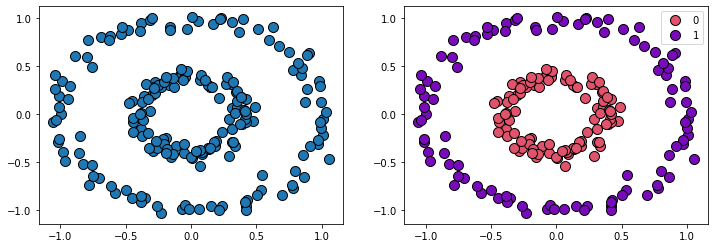

In [7]:
X = datasets.make_circles(n_samples=200, noise=0.06, factor=0.4)[0]
dbscan = DBSCAN(eps=0.3, min_samples=3)
dbscan.fit(X)
plot_X_dbscan(X, dbscan)

### How does it work?

- Iterative algorithm. (We won't go into the details.)  
- Based on the idea that clusters form dense regions in the data. 

![](img/DBSCAN_search.gif)

<!-- <img src="img/DBSCAN_search.gif" alt="" height="900" width="900">  -->

[Source](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)

### Two main hyperparameters
- `eps`: determines what it means for points to be "close"
- `min_samples`: determines the number of **neighboring points** we require to consider in order for a point to be part of a cluster

### Effect of `eps` hyperparameter

In [8]:
from ipywidgets import interactive

In [9]:
X, y = make_blobs(random_state=40, centers=2, n_samples=6)
interactive(lambda eps=1: plot_dbscan_with_labels(X, eps), eps=(1, 12, 1))

interactive(children=(IntSlider(value=1, description='eps', max=12, min=1), Output()), _dom_classes=('widget-i…

In [10]:
pd.DataFrame(euclidean_distances(X, X)).round()

,0,1,2,3,4,5
0,0.0,3.0,9.0,7.0,2.0,8.0
1,3.0,0.0,12.0,10.0,4.0,11.0
2,9.0,12.0,0.0,2.0,8.0,1.0
3,7.0,10.0,2.0,0.0,6.0,1.0
4,2.0,4.0,8.0,6.0,0.0,7.0
5,8.0,11.0,1.0,1.0,7.0,0.0


### Effect of `min_samples` hyperparameter

In [11]:
interactive(
    lambda min_samples=1: plot_dbscan_with_labels(X, eps=1.0, min_samples=min_samples),
    min_samples=(1, 5, 1),
)

interactive(children=(IntSlider(value=1, description='min_samples', max=5, min=1), Output()), _dom_classes=('w…

With eps=3 it works better

In [12]:
interactive(
    lambda min_samples=1: plot_dbscan_with_labels(X, eps=3.0, min_samples=min_samples),
    min_samples=(1, 5, 1),
)

interactive(children=(IntSlider(value=1, description='min_samples', max=5, min=1), Output()), _dom_classes=('w…

### K-Means vs. DBSCAN

- In DBSCAN, you do not have to specify the number of clusters! 
    - Instead, you have to tune `eps` and `min_samples`. 
- Unlike K-Means, DBSCAN doesn't have to assign all points to clusters. 
    - The label is -1 if a point is unassigned.
- Unlike K-Means, there is no `predict` method. 
    - DBSCAN only really clusters the existing points you have, not "new" or "test" points.

### More details on DBSCAN

- You'll find more details in the lecture notebook. 

There are three kinds of points.

- **Core points** are the points that have at least `min_samples` points in the neighborhood.

- **Border points** are the points with fewer than `min_samples` points in the neighborhood, but are connected to a core point. 

- **Noise points** are the points which do not belong to any cluster. In other words, the points which have less that `min_samples` point within distance `eps` of the starting point are noise points. 


- Default values for hyperparameters don't work well on toy datasets. 
- All points have been marked as noise with the default values for `eps` and `min_samples`
- Let's examine the effect of changing these hyperparameters. 
    - noise points: shown in white
    - core points: bigger
    - border points: smaller

### Illustration of hyperparameters `eps` and `min_samples`

min_samples: 2 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 2 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 2 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 2 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 3 eps: 1.000000  cluster: [-1  0  0 -1  0 -1  1  1  0  1 -1 -1]
min_samples: 3 eps: 1.500000  cluster: [0 1 1 1 1 0 2 2 1 2 2 0]
min_samples: 3 eps: 2.000000  cluster: [0 1 1 1 1 0 0 0 1 0 0 0]
min_samples: 3 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]
min_samples: 5 eps: 1.000000  cluster: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
min_samples: 5 eps: 1.500000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 2.000000  cluster: [-1  0  0  0  0 -1 -1 -1  0 -1 -1 -1]
min_samples: 5 eps: 3.000000  cluster: [0 0 0 0 0 0 0 0 0 0 0 0]


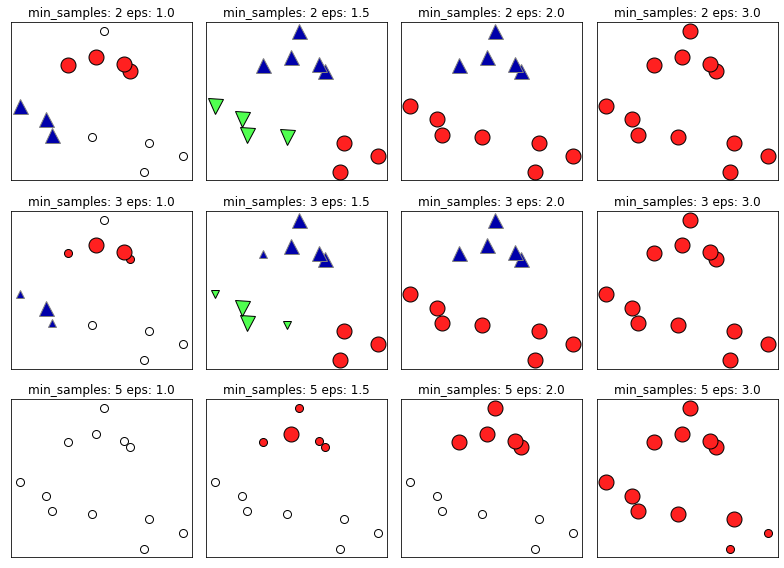

In [13]:
mglearn.plots.plot_dbscan()

### Evaluating DBSCAN clusters 
- We cannot use the elbow method to examine the goodness of clusters created with DBSCAN. 
- But we can use the silhouette method because it's not dependent on the idea of cluster centers. 

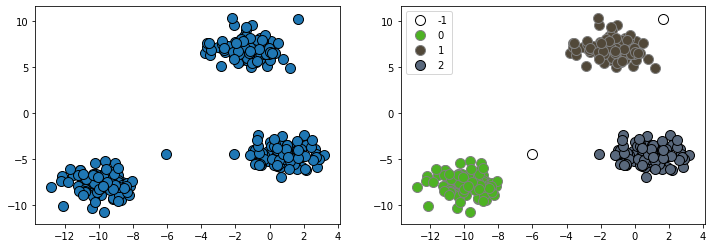

In [14]:
X, y = make_blobs(random_state=100, centers=3, n_samples=300)
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan.fit(X)
plot_X_dbscan(X, dbscan)

In [15]:
# Yellowbrick is designed to work with K-Means and not with DBSCAN.
# So it needs the number of clusters stored in n_clusters
# It also needs `predict` method to be implemented.
# So I'm implementing it here so that we can use Yellowbrick to show Silhouette plots.
n_clusters = len(set(dbscan.labels_))
dbscan.n_clusters = n_clusters
dbscan.predict = lambda x: dbscan.labels_

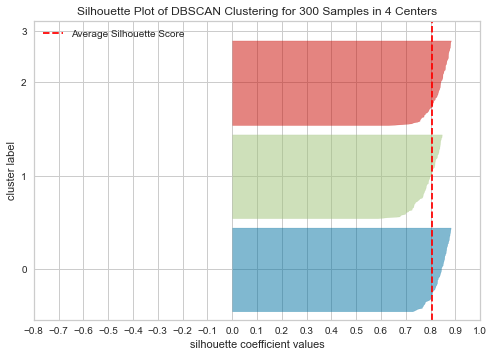

In [16]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(dbscan, colors="yellowbrick")
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show();

### Observations

- Increasing `eps` ($\uparrow$) (left to right in the plot above) means more points will be included in a cluster. 
    - `eps` = 1.0 either creates more clusters or more noise points, whereas eps=3.0 puts all points in one cluster with no noise points.  
- Increasing `min_samples` ($\uparrow$) (top to bottom in the plot above) means points in less dense regions will either be labeled as their own cluster or noise. 
    - `min_samples=2`, for instance, has none or only a fewer noise points whereas `min_samples=5` has several noise points. 
- Here `min_samples` = 2.0 or 3.0 and `eps` = 1.5 is giving us the best results. 
- In general, it's **not trivial to tune** these hyperparameters. 


### Summary: Pros and cons

- Pros
    - Can learn arbitrary cluster shapes
    - Can detect outliers 
- Cons
    - Cannot `predict` on new examples.  
    - Needs tuning of two non-obvious hyperparameters 

There is an improved version of DBSCAN called [`HDBSCAN` (hierarchical DBSCAN)](https://github.com/scikit-learn-contrib/hdbscan). 

### DBSCAN: failure cases

- DBSCAN is able to capture complex clusters. But this doesn't mean that `DBSCAN` always works better. It has its own problems! 
- DBSCAN doesn't do well when we have **clusters with different densities**. 
    - You can play with the hyperparameters but it's not likely to help much.

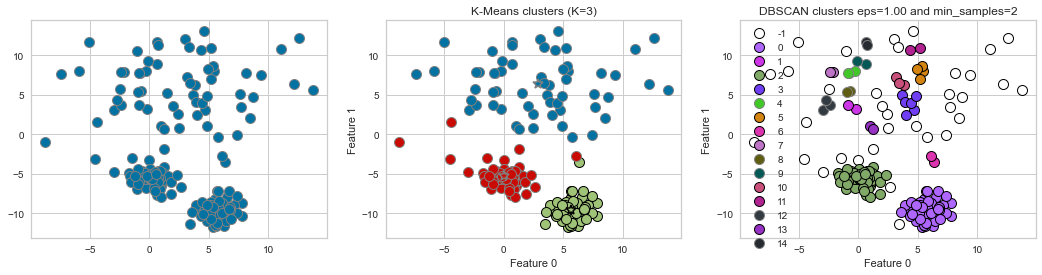

In [17]:
X_varied, y_varied = make_blobs(
    n_samples=200, cluster_std=[1.0, 5.0, 1.0], random_state=10
)
plot_k_means_dbscan_comparison(X_varied)

***Note***
There is also "hierarchical" clustering. We don't have time to talk about it. But if you want to know more about it, check out the notes from last year [here](https://github.com/UBC-CS/cpsc330/blob/v2.0/lectures/19_clustering.ipynb).

<br><br><br><br>

## Recommender systems motivation <a name="1"></a>

### What is a recommender system? 

- A recommender or a recommendation system **recommends** a particular product or service to users they are likely to consume. 

![](img/recommendation_system.png)

<!-- <img src="img/recommendation_system.png" alt="" height="900" width="900">  -->


### Example: Recommender Systems
- A client goes to Amazon to buy products. 
- Amazon has some information about the client. They also have information about **other clients buying similar products**. 
- What should they recommend to the client, so that they buy more products? 
- There's no "right" answer (no label). 
- The whole idea is to understand user behavior in order to recommend them products they are likely to consume. 

### Why should we care about recommendation systems? 

- Almost everything we buy or consume today is in some way or the other influenced by recommendation systems. 
    - Music (Spotify), videos (YouTube), news, books and products (Amazon), movies (Netflix), jokes, restaurants, dating , friends (Facebook), professional connections (Linkedin)
- Recommendation systems are at the core of the success of many companies. 
    - Amazon
    - [Netflix](https://help.netflix.com/en/node/100639)


### An example Capstone project: [QxMD](https://qxmd.com/)

- Present personalized journal article recommendations to health care professionals.   

### What **kind of data we need** to build recommendation systems? 

- **User ratings data** (most common)
- **Features related to items or users** 
- Customer purchase history data

### Main approaches

- Collaborative filtering 
    - "Unsupervised" learning 
    - We only have labels $y_{ij}$ (rating of user $i$ for item $j$). 
    - We learn features.  
- Content-based recommenders 
    - Supervised learning
    - Extract features $x_i$ of users and/or items and building a model to predict rating $y_i$ given $x_i$. 
    - Apply model to predict for new users/items. 
- Hybrid 
    - Combining collaborative filtering with content-based filtering
    

### The Netflix prize

![](img/netflix.png)

[Source](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

### The Netflix prize

- 100M ratings from 0.5M users on 18k movies.
- Grand prize was \$1M for first team to reduce squared error at least by 10%.
- Winning entry (and most entries) used collaborative filtering:
    - Methods that only looks at ratings, not features of movies/users.
- A simple collaborative filtering method that does really well:
   - Now adopted by many companies.

<br><br>

## Recommender systems problem 

### Problem formulation

- Most often the data for recommender systems come in as **ratings** for a set of items from a set of users. 
- We have two entities: $N$ **users** and $M$ **items**. 
- **Users** are consumers. 
- **Items** are the products or services offered.  
    - E.g., movies (Netflix), books (Amazon), songs (spotify), people (tinder)  
    
![](img/utility_matrix.png)

<!-- <img src="img/utility_matrix.png" alt="" height="900" width="900">  -->


### Utility matrix 

- A **utility matrix** is the matrix that captures **interactions** between $N$ **users** and $M$ **items**. 
- The interaction may come in different forms: 
    - ratings, clicks, purchases

![](img/utility_matrix.png)

<!-- <img src="img/utility_mat.png" alt="" height="900" width="900">  -->

### Utility matrix

- Below is a toy utility matrix. Here $N$ = 6 and $M$ = 5.  
- Each entry $y_{ij}$ ($i^{th}$ row and $j^{th}$ column) denotes the rating given by the user $i$ to item $j$. 
- We represent users in terms of items and items in terms of users. 

![](img/utility_matrix.png)

<!-- <img src="img/utility_matrix.png" alt="" height="900" width="900">  -->

### Sparsity of utility matrix

- The utility matrix is very sparse because usually users only interact with a few items. 
- For example: 
    - all Netflix users will have rated only a small percentage of content available on Netflix
    - all amazon clients will have rated only a small fraction of items among all items available on Amazon

### What do we predict? 
Given a utility matrix of $N$ users and $M$ items, **complete the utility matrix**. In other words, **predict missing values in the matrix**. 

![](img/utility_matrix.png)

<!-- <img src="img/utility_matrix.png" alt="" height="900" width="900">  -->

- Once we have predicted ratings, we can recommend items to users they are likely to rate higher. 

## Break (5 min)

![](img/eva-coffee.png)

<br><br><br><br>

### Example dataset: [Jester 1.7M jokes ratings dataset](https://www.kaggle.com/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset?select=jester_ratings.csv)

- We'll use a sample of [Jester 1.7M jokes ratings dataset](https://www.kaggle.com/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset) to demonstrate different recommendation systems. 

The dataset comes with two CSVs
- A CSV containing ratings (-10.0 to +10.0) of 150 jokes from 59,132 users. 
- A CSV containing joke IDs and the actual text of jokes. 

> Some jokes might be offensive. Please do not look too much into the actual text data if you are sensitive to such language.

- Recommendation systems are most effective when you have a large amount of data.
- But we are only taking a sample here for speed.

In [18]:
filename = "data/jester_ratings.csv"
ratings_full = pd.read_csv(filename)
ratings = ratings_full[ratings_full["userId"] <= 4000]

In [19]:
ratings.head()

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


In [20]:
user_key = "userId"
item_key = "jokeId"

### Dataset stats 

In [21]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141362 entries, 0 to 141361
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  141362 non-null  int64  
 1   jokeId  141362 non-null  int64  
 2   rating  141362 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 4.3 MB


In [22]:
def get_stats(ratings, item_key="jokeId", user_key="userId"):
    print("Number of ratings:", len(ratings))
    print("Average rating:  %0.3f" % (np.mean(ratings["rating"])))
    N = len(np.unique(ratings[user_key]))
    M = len(np.unique(ratings[item_key]))
    print("Number of users (N): %d" % N)
    print("Number of items (M): %d" % M)
    print("Size of non-sparse matrix (N x M): %d" % (N*M))
    print("Fraction non-nan ratings: %0.3f" % (len(ratings) / (N * M)))
    return N, M


N, M = get_stats(ratings)

Number of ratings: 141362
Average rating:  1.200
Number of users (N): 3635
Number of items (M): 140
Size of non-sparse matrix (N x M): 508900
Fraction non-nan ratings: 0.278


### Creating utility matrix

- Let's construct utility matrix with `number of users` rows and `number of items` columns from the ratings data. 

> Note we are constructing a non-sparse matrix for demonstration purpose here. In real life it's recommended that you work with sparse matrices. 
> 
> (Optional) See the Python Side Note below for one example approach.

In [23]:
# not all possible jokeId values are present in the data
unused_jokeId = set(range(ratings[item_key].max()+1)) - set(ratings[item_key])
len(unused_jokeId), unused_jokeId

(11, {0, 1, 2, 3, 4, 6, 9, 10, 11, 12, 14})

In [24]:
# not all possible userId values are present in the data
unused_userId = set(range(ratings[user_key].max()+1)) - set(ratings[user_key])
len(unused_userId), sorted(unused_userId)[:10]  # too many; just show the first 10

(366, [0, 20, 21, 30, 31, 32, 36, 69, 70, 78])

Thus, we need to be able to map back and forth between `user_key` and a continuous range of IDs, which is made possible by `user_mapper` and `user_inverse_mapper` below. The same holds for `item_key`.

In [25]:
user_mapper = dict(zip(ratings[user_key].unique(), range(N)))
item_mapper = dict(zip(ratings[item_key].unique(), range(M)))
user_inverse_mapper = dict(zip(user_mapper.values(), user_mapper.keys()))
item_inverse_mapper = dict(zip(item_mapper.values(), item_mapper.keys()))


def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y


Y_mat = create_Y_from_ratings(ratings, N, M)
Y_mat.shape

(3635, 140)

### Utility matrix for the example problem
- Rows represent users.
- Columns represent items (jokes in our case).
- Each **cell gives the rating** given by the user to the corresponding joke. 
- **Users are features** for jokes and **jokes are features** for users.
- We want to **predict the missing** entries. 

In [26]:
pd.DataFrame(Y_mat)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0.219,-9.281,-9.281,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,-9.156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-9.688,9.938,9.531,9.938,0.406,3.719,9.656,-2.688,-9.562,-9.125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-9.844,-9.844,-7.219,-2.031,-9.938,-9.969,-9.875,-9.812,-9.781,-6.844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.812,-4.500,-4.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.906,4.750,-5.906,-0.406,-4.031,3.875,6.219,5.656,6.094,5.406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,NaN,-9.812,-0.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3631,NaN,-9.844,7.531,-9.719,-9.344,3.875,9.812,8.938,8.375,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3632,NaN,-1.906,3.969,-2.312,-0.344,-8.844,4.188,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3633,NaN,-8.875,-9.156,-9.156,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br><br><br><br>

## Baseline Approaches


- Recall that our goal is to predict missing entries in the utility matrix above. 

### Evaluation

- We'll try a number of methods to do this. 
- Although there is no notion of "accurate" recommendations, we need a way to evaluate our predictions so that we'll be able to compare different methods.
- Although we are doing unsupervised learning, we'll split the data and evaluate our predictions as follows.  

### Data splitting 

- We split the ratings into train and validation sets. 
- It's **easier to split the ratings data** instead of splitting the utility matrix.
- Don't worry about `y`; we're not really going to use it.  

In [27]:
X = ratings.copy()
y = ratings[user_key]  # not really used
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape

((113089, 3), (28273, 3))

Now we will create utility matrices for train and validation splits. 

In [28]:
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

In [29]:
train_mat.shape, valid_mat.shape

((3635, 140), (3635, 140))

- `train_mat` has only ratings from the train set and `valid_mat` has only ratings from the valid set.
- During training we assume that we do not have access to some of the available ratings. We predict these ratings and evaluate them against ratings in the validation set. 

### Questions for you

- How do train and validation utility matrices differ? 
- Why are utility matrices for train and validation sets are of the same shape?
<br><br>

**Answer:**

- The training matrix `train_mat` is of shape N by M but only has ratings from `X_train` and all other ratings missing. 
- The validation matrix `valid_mat` is also of shape N by M but it only has ratings `X_valid` and all other ratings missing. 
- They have the same shape because both have the same number of users and items; that's how we have constructed them. 

### Evaluation

- Now that we have train and validation sets, how do we evaluate our predictions?
- You can calculate the **error between actual ratings and predicted ratings** with metrics of your choice. 
    - Most **common metrics** are **MSE** or **RMSE**.

- The `error` function below calculates RMSE and `evaluate` function prints train and validation RMSE.  

In [30]:
def error(X1, X2):
    """
    Returns the root mean squared error.
    """
    return np.sqrt(np.nanmean((X1 - X2) ** 2))


def evaluate(pred_X, train_X, valid_X, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_X, train_X)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_X, valid_X)))

<br><br>

### Baselines

Let's first try some simple approaches to predict missing entries. 

1. Global average baseline
2. [$k$-Nearest Neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)    
    

### Global average baseline

- Let's examine RMSE of the global average baseline. 
- In this baseline we **predict everything as the global average rating**

In [31]:
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
1,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
2,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
3,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741
4,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,...,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741,1.20741


In [32]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 5.75
Global average valid RMSE: 5.77


### [$k$-nearest neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

- Can we try $k$-nearest neighbours type imputation? 
- Impute missing values using the **mean value from $k$ nearest neighbours** found in the training set. 
- Calculate distances between examples using features where neither value is missing. 

![](img/utility_matrix.png)

<!-- <img src="img/utility_matrix.png" alt="" height="900" width="900">  -->

In [33]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)
train_mat_imp = imputer.fit_transform(train_mat)

In [34]:
pd.DataFrame(train_mat_imp)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-5.9406,-9.2810,-9.2810,-6.7810,0.8750,-9.6560,-9.0310,-7.4690,-8.7190,-9.1560,...,-4.5311,1.8968,0.6905,-3.1218,1.2843,-2.6063,-0.1812,-1.3937,1.7625,-0.4092
1,2.3405,9.9380,9.5310,9.9380,0.4060,3.7190,9.6560,-2.6880,4.3438,-9.1250,...,2.2437,3.1719,5.0251,5.1812,8.2407,5.9311,5.8375,6.3812,1.1687,6.2532
2,-9.8440,-3.5750,-7.2190,-2.0310,-9.9380,-9.9690,-9.8750,-9.8120,-9.7810,-6.8440,...,-4.4186,-3.1156,-1.5655,-5.6250,0.3720,-4.0439,-6.0500,-5.5563,-5.4125,-5.5874
3,-5.8120,-2.4624,-4.9060,-2.7781,-0.0532,-3.8594,1.7031,-0.3687,1.8469,0.0593,...,-1.6250,2.1469,2.8875,1.6845,-0.0844,-0.0156,1.2595,3.8219,3.1971,5.0249
4,1.3157,4.7500,1.8658,-0.4060,1.7937,3.8750,6.2190,1.9220,6.0940,5.4060,...,-0.2844,1.1313,4.0157,3.0344,4.0406,0.5218,4.3594,4.0968,3.9250,3.9657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,-0.7750,-9.8120,-0.0620,-2.8218,-4.1470,-4.8281,3.0218,-2.8782,-1.0125,0.0688,...,-6.6844,3.0531,2.8687,1.5281,4.5002,-0.1878,2.5156,4.0908,2.3563,5.0406
3631,2.5188,-5.0625,-0.4001,-9.7190,-9.3440,-1.6408,-4.1187,8.9380,8.3750,-0.9314,...,-4.0344,7.9155,3.4282,4.2968,6.7968,7.3999,1.8500,5.8219,5.1812,2.8437
3632,0.1749,-1.9060,3.9690,-1.3844,-0.3440,-8.8440,4.1880,-1.5564,5.0593,0.3343,...,-4.0126,2.8344,2.4499,2.9312,2.3750,-0.4062,1.4375,3.9750,-1.2220,2.8375
3633,-4.5937,-6.4907,-6.1594,-9.1560,-7.1437,-6.5406,3.8718,-1.7782,-3.7406,-0.6406,...,-4.6938,3.4186,4.9968,-0.1626,2.2656,-0.7750,4.6781,1.2658,0.4595,0.1843


In [35]:
evaluate(train_mat_imp, train_mat, valid_mat, model_name="KNN imputer")

KNN imputer train RMSE: 0.00
KNN imputer valid RMSE: 4.79


### Finding [nearest neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html)

- We can look at nearest neighbours of a query item. 
- Here our columns are jokes, and **users are features for jokes**, and we'll have to find nearest neighbours of columns vectors. 

In [36]:
pd.DataFrame(train_mat_imp)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-5.9406,-9.2810,-9.2810,-6.7810,0.8750,-9.6560,-9.0310,-7.4690,-8.7190,-9.1560,...,-4.5311,1.8968,0.6905,-3.1218,1.2843,-2.6063,-0.1812,-1.3937,1.7625,-0.4092
1,2.3405,9.9380,9.5310,9.9380,0.4060,3.7190,9.6560,-2.6880,4.3438,-9.1250,...,2.2437,3.1719,5.0251,5.1812,8.2407,5.9311,5.8375,6.3812,1.1687,6.2532
2,-9.8440,-3.5750,-7.2190,-2.0310,-9.9380,-9.9690,-9.8750,-9.8120,-9.7810,-6.8440,...,-4.4186,-3.1156,-1.5655,-5.6250,0.3720,-4.0439,-6.0500,-5.5563,-5.4125,-5.5874
3,-5.8120,-2.4624,-4.9060,-2.7781,-0.0532,-3.8594,1.7031,-0.3687,1.8469,0.0593,...,-1.6250,2.1469,2.8875,1.6845,-0.0844,-0.0156,1.2595,3.8219,3.1971,5.0249
4,1.3157,4.7500,1.8658,-0.4060,1.7937,3.8750,6.2190,1.9220,6.0940,5.4060,...,-0.2844,1.1313,4.0157,3.0344,4.0406,0.5218,4.3594,4.0968,3.9250,3.9657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,-0.7750,-9.8120,-0.0620,-2.8218,-4.1470,-4.8281,3.0218,-2.8782,-1.0125,0.0688,...,-6.6844,3.0531,2.8687,1.5281,4.5002,-0.1878,2.5156,4.0908,2.3563,5.0406
3631,2.5188,-5.0625,-0.4001,-9.7190,-9.3440,-1.6408,-4.1187,8.9380,8.3750,-0.9314,...,-4.0344,7.9155,3.4282,4.2968,6.7968,7.3999,1.8500,5.8219,5.1812,2.8437
3632,0.1749,-1.9060,3.9690,-1.3844,-0.3440,-8.8440,4.1880,-1.5564,5.0593,0.3343,...,-4.0126,2.8344,2.4499,2.9312,2.3750,-0.4062,1.4375,3.9750,-1.2220,2.8375
3633,-4.5937,-6.4907,-6.1594,-9.1560,-7.1437,-6.5406,3.8718,-1.7782,-3.7406,-0.6406,...,-4.6938,3.4186,4.9968,-0.1626,2.2656,-0.7750,4.6781,1.2658,0.4595,0.1843


### $k$-nearest neighbours on a query joke
- Let's **transpose the matrix**.  

In [37]:
item_user_mat = train_mat_imp.T

In [38]:
jokes_df = pd.read_csv("data/jester_items.csv")
jokes_df.head()

,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I have bad news for you.You have\ncancer and Alzheimer's disease"". \nThe man replies ""Well,thank God I don't have cancer!""\n"
1,2,"This couple had an excellent relationship going until one day he came home\nfrom work to find his girlfriend packing. He asked her why she was leaving him\nand she told him that she had heard awful things about him. \n\n""What could they possibly have said to make you move out?"" \n\n""They told me that you were a pedophile."" \n\nHe replied, ""That's an awfully big word for a ten year old."" \n"
2,3,Q. What's 200 feet long and has 4 teeth? \n\nA. The front row at a Willie Nelson Concert.\n
3,4,Q. What's the difference between a man and a toilet? \n\nA. A toilet doesn't follow you around after you use it.\n
4,5,"Q.\tWhat's O. J. Simpson's Internet address? \nA.\tSlash, slash, backslash, slash, slash, escape.\n"


In [39]:
id_joke_map = dict(zip(jokes_df.jokeId, jokes_df.jokeText))

For example, let's look at the the 8th joke:

In [40]:
print(id_joke_map[item_inverse_mapper[8]])

Q: If a person who speaks three languages is called "tri-lingual," and
a person who speaks two languages is called "bi-lingual," what do call
a person who only speaks one language?

A: American! 



In [41]:
from sklearn.neighbors import NearestNeighbors


def get_topk_recommendations(X, query_ind=0, metric="cosine", k=5):
    query_idx = item_inverse_mapper[query_ind]
    model = NearestNeighbors(n_neighbors=k, metric=metric)
    model.fit(X)
    neigh_ind = model.kneighbors([X[query_ind]], k, return_distance=False).flatten()
    neigh_ind = np.delete(neigh_ind, np.where(query_ind == query_ind))
    recs = [id_joke_map[item_inverse_mapper[i]] for i in neigh_ind]
    print("Query joke: ", id_joke_map[query_idx])

    return pd.DataFrame(data=recs, columns=["top recommendations"])


get_topk_recommendations(item_user_mat, query_ind=8, metric="cosine", k=5)

Query joke:  Q: If a person who speaks three languages is called "tri-lingual," and
a person who speaks two languages is called "bi-lingual," what do call
a person who only speaks one language?

A: American! 



,top recommendations
0,"Q: What is the difference between George Washington, Richard Nixon,\nand Bill Clinton?\n\nA: Washington couldn't tell a lie, Nixon couldn't tell the truth, and\nClinton doesn't know the difference.\n"
1,"A man in a hot air balloon realized he was lost. He reduced altitude and spotted a woman below. He descended a bit more and shouted, ""Excuse me, can you help me? I promised a friend I would meet him an hour ago, but I don't know where I am."" The woman below replied, ""You are in a hot air balloon hovering approximately 30 feet above the ground. You are between 40 and 41 degrees north latitude and between 59 and 60 degrees west longitude."" ""You must be an engineer,"" said the balloonist. ""I am,"" replied the woman. ""How did you know?"" ""Well,"" answered the balloonist, ""everything you told me is technically correct, but I have no idea what to make of your information, and the fact is, I am still lost. Frankly, you've not been much help so far."" The woman below responded, ""You must be in management."" ""I am,"" replied the balloonist, ""but how did you know?"" ""Well,"" said the woman, ""you don't know where you are or where you are going. You have risen to where you are due to a large quantity of hot air. You made a promise that you have no idea how to keep, and you expect people beneath you to solve your problems. The fact is, you are in exactly the same position you were in before we met, but now, somehow, it's my fault!"""
2,If pro- is the opposite of con- then congress must be the opposite\nof progress.\n
3,"Arnold Swartzeneger and Sylvester Stallone are making a movie about\nthe lives of the great composers. \nStallone says ""I want to be Mozart."" \nSwartzeneger says: ""In that case... I'll be Bach.""\n"


**Question**
- Instead of imputation, what would be the consequences if we replace `nan` with zeros so that we can calculate distances between vectors? 

<br><br>
**Answer**

It's not a good idea replace ratings with 0, because 0 can be an actual rating value in our case. 

### What to do with predictions? 
- Once you have predictions, you can sort them based on ratings and recommend items with highest ratings.  

<br><br><br><br>

## Collaborative filtering 

- One of the most popular approach for recommendation systems. 
- Approach used by the winning entry (and most of the entries) in the Netflix competition. 
- An unsupervised approach
    - Only uses the user-item interactions given in the ratings matrix. 
- **Intuition**
    - We may have **similar users** and **similar items** which can help us predict missing entries. 
    - **Leverage social information** to provide recommendations. 

### Problem 

- Given a utility matrix with many missing entries, how can we predict missing ratings?  

$$
\begin{bmatrix} 
? & ? & \checkmark  & ? & \checkmark\\
\checkmark & ? & ?  & ? & ?\\
? & \checkmark & \checkmark  & ? & \checkmark\\
? & ? & ?  & ? & ?\\
? & ? & ? & \checkmark & ?\\
? & \checkmark & \checkmark  & ? & \checkmark
\end{bmatrix}
$$

> Note: rating prediction $\neq$ Classification or regression 

### Classification or regression

- We have $X$ and targets for some rows in $X$. 
- We want to predict the last column (target column).  

$$
\begin{bmatrix} 
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\end{bmatrix}
$$

### Rating prediction 

- Ratings data has many missing values in the utility matrix. There is no special target column. We want to predict the missing entries in the matrix. 
- Since our goal is to **predict** ratings, usually the utility matrix is referred to as $Y$ matrix. 

$$
\begin{bmatrix} 
? & ? & \checkmark  & ? & \checkmark\\
\checkmark & ? & ?  & ? & ?\\
? & \checkmark & \checkmark  & ? & \checkmark\\
? & ? & ?  & ? & ?\\
? & ? & ? & \checkmark & ?\\
? & \checkmark & \checkmark  & ? & \checkmark
\end{bmatrix}
$$


<br><br>

- I'll show you how to use a package which implements collaborative filtering. 
- We don't have sufficient background to understand how it works under the hood.  

### Rating prediction using the surprise package

- We'll be using a package called [Surprise](https://surprise.readthedocs.io/en/stable/index.html). 
- The **collaborative filtering algorithm** we use in this package is called `SVD`. 

`conda install -n cpsc330 -c conda-forge scikit-surprise`

Let's try it out on our Jester dataset utility matrix.  

In [42]:
import surprise
from surprise import SVD, Dataset, Reader, accuracy

reader = Reader()
data = Dataset.load_from_df(ratings, reader)  # Load the data

# I'm being sloppy here. Probably there is a way to create validset from our already split data.
trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)  # Split the data

In [43]:
k = 10
svd_algo = SVD(n_factors=k, random_state=42)
svd_algo.fit(trainset)
svd_preds = svd_algo.test(validset)
accuracy.rmse(svd_preds, verbose=True)

RMSE: 5.2893


5.28926338380112

- No big improvement over the global baseline (RMSE=5.77). 
- Probably because we are only considering a sample. 

### Cross-validation for recommender systems

- We can also carry out cross-validation and grid search with this package. 
- Let's look at an example of cross-validation. 

In [44]:
from surprise.model_selection import cross_validate

results = cross_validate(svd_algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    5.3261  5.2628  5.2978  5.2603  5.2617  5.2817  0.0263  
MAE (testset)     4.2399  4.1860  4.2069  4.1881  4.1835  4.2009  0.0212  
Fit time          2.43    2.41    2.08    2.07    2.03    2.20    0.18    
Test time         0.17    0.31    0.19    0.17    0.25    0.22    0.05    


In [45]:
pd.DataFrame(results).mean()

test_rmse    5.281740
test_mae     4.200891
fit_time     2.204306
test_time    0.218681
dtype: float64

- Jester dataset is available as one of the built-in datasets in this package and you can load it as follows and run cross-validation as follows. 
- It takes a bit of time to run, so the cells below are set `Raw`. If you want to run them, first change them to type `Code`.

### What is content-based filtering? 

- Supervised machine learning approach
- In **collaborative** filtering we assumed that we **only have ratings** data. 
- Usually there is **some information on items and users** available. 
- Examples
    - Netflix can describe movies as action, romance, comedy, documentaries. 
    - Amazon could describe books according to topics: math, languages, history. 
    - Tinder could describe people according to age, location, employment.
- Can we use this information to predict ratings in the utility matrix?   
    - Yes!

### Hybrid filtering

- Combining advantages of collaborative filtering and content-based filtering

<br><br><br><br>

## Final comments and summary <a name="1"></a>

### Formulating the problem of recommender systems 

- We are given ratings data. 
- We use this data to create **utility matrix** which encodes interactions between users and items. 
- The utility matrix has many missing entries. 
- We defined recommendation systems problem as **matrix completion problem**. 

### Collaborative filtering 

- Collaborative filtering is an unsupervised approach to recommendation systems.

### Evaluation 

- We split the data similar to supervised systems. 
- We evaluate recommendation systems using traditional regression metrics such as MSE or RMSE. 
- But real evaluation of recommender system can be very tricky because there is no ground truth. 
- We have been using RMSE due to the lack of a better measure.  
- What we actually want to measure is the interest that our user has in the recommended items. 

### Precision at N

- Another popular evaluation metric from information retrieval is precision at N. 
- Suppose you recommend top-N items, then we look at the proportion of the items that are relevant. 
$$\text{Precision at } N = \frac{r}{N}$$
- For example, $r$ could be the number of elements in your list that the user rated.
- In this way, you would know that your system is recommending items that the user had interest in!

### Some thoughts on recommendation systems  
- Be mindful of the consequences recommendation systems. 
- Companies such as Amazon,  Netflix, Facebook, Google (YouTube), which extensively use recommendation systems, are profit-driven and so they design these systems to maximize user attention; their focus is not necessarily human well-being. 
- There are tons of news and research articles on serious consequences of recommendation systems.  

### Some thoughts on recommendation systems  

- Some weird stories which got media attention.   
[How Target Figured Out A Teen Girl Was Pregnant Before Her Father Did](https://www.forbes.com/sites/kashmirhill/2012/02/16/how-target-figured-out-a-teen-girl-was-pregnant-before-her-father-did/?sh=3171af136668)
- More serious consequences are in political contexts. 
    - [Facebook Admits It Was Used to Incite Violence in Myanmar](https://www.nytimes.com/2018/11/06/technology/myanmar-facebook.html)
    - [YouTube Extremism and the Long Tail](https://www.theatlantic.com/politics/archive/2018/03/youtube-extremism-and-the-long-tail/555350/)    

### My advice

- Ask hard and uncomfortable questions to yourself (and to your employer if possible) before implementing and deploying such systems.  

<br><br><br><br>

### Resources 

- [Collaborative filtering for recommendation systems in Python, by N. Hug](https://www.youtube.com/watch?v=z0dx-YckFko)
- [An interesting talk: The paradox of choice](https://www.ted.com/talks/barry_schwartz_the_paradox_of_choice)
- [How Netflix’s Recommendations System Works](https://help.netflix.com/en/node/100639)
- [Hands on Recommendation Systems with Python](https://learning.oreilly.com/library/view/hands-on-recommendation-systems/9781788993753/)

<br><br><br><br>

### Questions for class discussion <a name="questions"></a>

### True/False questions

1. To evaluate rating predictions we split the data. The shapes of validation utility matrix and train utility matrix are the same. 
2. It would be reasonable to impute missing values in the utility matrix by taking the average of the ratings given to an item by similar users.  
3. You might be able to predict missing ratings in the utility matrix using supervised machine learning methods. 
<br><br><br><br>

- Discuss a strange/scary experience you had with recommendation systems. 

---

__Python Side Note__

### (Optional) Handling Sparse Matrices

One option to properly handle sparse matrices is to use `scipy` and `Pandas`.

In particular, we will make use of the COOrdinate (`coo`) format, which is also known as the `ijv` or `triplet` format. The following functions are useful to get started:
- [scipy.sparse.coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html)
- [pd.DataFrame.sparse.from_spmatrix](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sparse.from_spmatrix.html)
 

In [48]:
import scipy
np.random.seed(1)
n = 30
I = np.random.choice(range(6), n)  # possible rows: 0 to 5
J = np.random.choice(range(4, 15), n)  # possible columns: 4 to 14
V = [1000] * n  # values
pd.DataFrame([I, J, V], index=['rows: I', 'cols: J', 'values: V']).iloc[:, :18]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
rows: I,5,3,4,0,1,3,5,0,0,1,4,5,4,1,2,4,5,2
cols: J,13,13,11,10,13,5,4,5,12,12,7,14,13,12,11,7,10,9
values: V,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


We can use the above (`I`,`J`,`V`) data and `coo_matrix` function to create a sparse matrix, and we can conveniently convert it to a dense matrix using `todense()` function if needed. (If the same `i` and `j` for a cell repeat, the a value for that cell will be a multiple of `1000` here.)

In [49]:
coo_mat = scipy.sparse.coo_matrix((V, (I, J)))
pd.DataFrame(coo_mat.todense())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,1000,0,0,0,0,1000,0,1000,1000,0
1,0,0,0,0,1000,0,0,1000,0,0,0,0,2000,1000,0
2,0,0,0,0,0,0,0,0,1000,1000,0,1000,0,0,1000
3,0,0,0,0,0,1000,0,0,0,0,0,0,0,2000,0
4,0,0,0,0,0,1000,0,3000,1000,0,0,1000,1000,1000,0
5,0,0,0,0,1000,1000,1000,0,0,0,1000,0,0,1000,1000


Much preferably, we can instead use `from_spmatrix()` function to create a `DataFrame` which internally uses a **sparse matrix** format without converting the data into a dense format first:

In [50]:
pd.DataFrame.sparse.from_spmatrix(coo_mat)  # notice we are not calling todense()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,1000,0,0,0,0,1000,0,1000,1000,0
1,0,0,0,0,1000,0,0,1000,0,0,0,0,2000,1000,0
2,0,0,0,0,0,0,0,0,1000,1000,0,1000,0,0,1000
3,0,0,0,0,0,1000,0,0,0,0,0,0,0,2000,0
4,0,0,0,0,0,1000,0,3000,1000,0,0,1000,1000,1000,0
5,0,0,0,0,1000,1000,1000,0,0,0,1000,0,0,1000,1000


Now, we can use `memory_usage()` function to compare how much memory is used for each column of the dense and sparse representations of the same data:

In [51]:
dense_vs_sparse = pd.DataFrame({
    "dense (bytes)": pd.DataFrame(coo_mat.todense()).memory_usage(index=False),
    "sparse (bytes)": pd.DataFrame.sparse.from_spmatrix(coo_mat).memory_usage(index=False)})

dense_vs_sparse.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
dense (bytes),48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
sparse (bytes),0,0,0,0,24,48,12,24,24,12,24,24,36,60,24


In [52]:
dense_vs_sparse.sum()

dense (bytes)     720
sparse (bytes)    312
dtype: int64

The difference will be significant on large and highly sparse datasets.

<br>

__Python Side Note End__

---